In [1]:
#%matplotlib inline
import matplotlib.pylab as plt
import mpld3
mpld3.enable_notebook()


# Rectangle Selector


Do a mouseclick somewhere, move the mouse to some destination, release
the button.  This class gives click- and release-events and also draws
a line or a box from the click-point to the actual mouseposition
(within the same axes) until the button is released.  Within the
method 'self.ignore()' it is checked whether the button from eventpress
and eventrelease are the same.


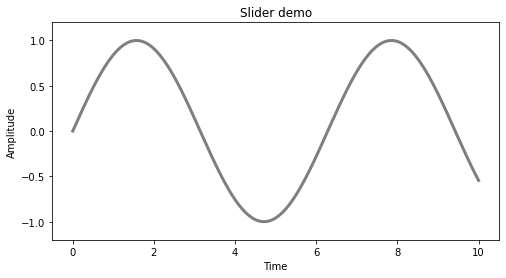

In [2]:
class SliderView(mpld3.plugins.PluginBase):
    """ Add slider and JavaScript / Python interaction. """

    JAVASCRIPT = """
    mpld3.register_plugin("sliderview", SliderViewPlugin);
    SliderViewPlugin.prototype = Object.create(mpld3.Plugin.prototype);
    SliderViewPlugin.prototype.constructor = SliderViewPlugin;
    SliderViewPlugin.prototype.requiredProps = ["idline", "callback_func"];
    SliderViewPlugin.prototype.defaultProps = {}

    function SliderViewPlugin(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    SliderViewPlugin.prototype.draw = function(){
      var line = mpld3.get_element(this.props.idline);
      var callback_func = this.props.callback_func;

      var div = d3.select("#" + this.fig.figid);

      // Create slider
      div.append("input").attr("type", "range").attr("min", 0).attr("max", 10).attr("step", 0.1).attr("value", 1)
          .on("change", function() {
              var command = callback_func + "(" + this.value + ")";
              console.log("running "+command);
              var callbacks = { 'iopub' : {'output' : handle_output}};
              var kernel = IPython.notebook.kernel;
              kernel.execute(command, callbacks, {silent:false});
          });

      function handle_output(out){
        //console.log(out);
        var res = null;
        // if output is a print statement
        if (out.msg_type == "stream"){
          res = out.content.data;
        }
        // if output is a python object
        else if(out.msg_type === "pyout"){
          res = out.content.data["text/plain"];
        }
        // if output is a python error
        else if(out.msg_type == "pyerr"){
          res = out.content.ename + ": " + out.content.evalue;
          alert(res);
        }
        // if output is something we haven't thought of
        else{
          res = "[out type not implemented]";  
        }

        // Update line data
        line.data = JSON.parse(res);
        line.elements()
          .attr("d", line.datafunc(line.data))
          .style("stroke", "black");

       }

    };
    """

    def __init__(self, line, callback_func):
        self.dict_ = {"type": "sliderview",
                      "idline": mpld3.utils.get_id(line),
                      "callback_func": callback_func}
        
import numpy as np

def updateSlider(val1):
    t = np.linspace(0, 10, 500)
    y = np.sin(val1*t)
    return map(list, list(zip(list(t), list(y))))

fig, ax = plt.subplots(figsize=(8, 4))

t = np.linspace(0, 10, 500)
y = np.sin(t)
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')

# create the line object
line, = ax.plot(t, y, '-k', lw=3, alpha=0.5)
ax.set_ylim(-1.2, 1.2)
ax.set_title("Slider demo")

mpld3.plugins.connect(fig, SliderView(line, callback_func="updateSlider"))